# Exercise 3.1: Dynamic Programming

## a) Implementation GPI

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Define GridWorld environment as in exercise 2.1 (adjusted so no teleportation happens)
class GridWorldEnv():
    def __init__(self, grid_size=5):
        # Initialize 5x5 grid as a 5x5 matrix with zeros
        self.grid_size = grid_size
        self.state_space = np.zeros((grid_size, grid_size))
        self.agent_position = (0, 0)
        self.action_space = [0,1,2,3] # ["south", "north", "east", "west"]
        self.reward = 0

    def convert_action_to_direction(self, action):
        if action == 0:
            return "south"
        elif action == 1:
            return "north"
        elif action == 2:
            return "east"
        elif action == 3:
            return "west"

    def step(self, action, state):
        # Initialize reward as 0
        self.reward = 0
        # Update agent position for special states independently of action
        if state == (0, 1):
            new_position = (4, 1)
        elif state == (0, 3):
            new_position = (2, 3)
        # Update agent position based on action for all other states
        else:
            if action == 0:
                new_position = (state[0] + 1, state[1])
            elif action == 1:
                new_position = (state[0] - 1, state[1])
            elif action == 2:
                new_position = (state[0], state[1] + 1)
            elif action == 3:
                new_position = (state[0], state[1] - 1)
        
        # Check for out of bounds, update position and give -1 reward for going out of bounds
        if new_position[0] < 0 or new_position[0] > 4 or new_position[1] < 0 or new_position[1] > 4:    
            new_position = (
                max(0, min(new_position[0], 4)),
                max(0, min(new_position[1], 4))
            )
            self.reward = -1
            self.agent_position = new_position

        # Handle special states
        elif new_position == (0, 1):
            self.reward = 10
        elif new_position == (0, 3):
            self.reward = 5

        # Update agent position
        self.agent_position = new_position
        return self.agent_position, self.reward

    def reset(self):
        self.agent_position = (0, 0)
        self.reward = 0

    def render(self):
        print(self.grid)
        print(f"Agent position: {self.agent_position}")
        print(f"Reward: {self.reward}")

env = GridWorldEnv()
# Define random policy
random_policy = 0.25 * np.ones((5, 5, 4))


In [11]:
# Implementation of state value iteration with bellman equation as in exercise 2.1 (adjusted for no teleportation)

def policy_evaluation_state_values(env, gamma=0.9, threshold=1e-3, policy=random_policy):
    state_values = np.zeros((env.grid_size, env.grid_size))
    state_values_total = [state_values.copy()]
    iteration_count = 0
    
    while True:
        iteration_count += 1  
        new_state_values = np.zeros((env.grid_size, env.grid_size))
        # Iterate over all states
        for i in range(env.grid_size):
            for j in range(env.grid_size):
                # Adjust state values for special states to their target states
                if (i, j) == (0, 1):
                    new_state_values[i, j] = 10 + gamma * state_values[4, 1]
                elif (i, j) == (0, 3):
                    new_state_values[i, j] = 5 + gamma * state_values[2, 3]
                else:
                    # Update state value using the state value bellman equation for each state
                    for action in env.action_space:
                        agent_position, reward = env.step(action, (i, j))
                        new_state_values[i, j] += policy[i, j, action] * (reward + gamma * state_values_total[-1][agent_position[0], agent_position[1]])
        
        state_values_total.append(new_state_values.copy())
        
        # Check for convergence
        if np.max(np.abs(new_state_values - state_values)) < threshold:
            break
        
        state_values = new_state_values
    
    print(f"{iteration_count} iterations to evaluate state values")
    return np.array(state_values_total)

# Improve policy 
def policy_improvement(env, state_values, gamma=0.9):
    new_policy = np.zeros((5, 5, 4))
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i, j) == (0, 1):
                new_policy[i, j, :] = [1, 0, 0, 0]
            elif (i, j) == (0, 3):
                new_policy[i, j, :] = [1, 0, 0, 0]
            else:
                neighboring_state_values = []
                for action in env.action_space:
                    agent_position, reward = env.step(action, (i, j))
                    neighboring_state_values.append(reward + gamma * state_values[agent_position[0], agent_position[1]])
                highest_value = np.max(neighboring_state_values)
                best_actions = np.where(neighboring_state_values == highest_value)[0]
                new_policy[i, j, best_actions] = 1 / len(best_actions)
    return new_policy


In [12]:
# Implementing general policy iteration using 1-step lookahead with value function

def policy_iteration_state_values(env, gamma=0.9, threshold=1e-6, starting_policy=random_policy):
    # Compute starting state values
    policy_total = []
    starting_state_values_total = policy_evaluation_state_values(env, policy=starting_policy)
    new_state_values = starting_state_values_total[-1]
    state_values_over_time = np.array([new_state_values.copy()])
    policy_total.append(policy_improvement(env, new_state_values, gamma))

    while True:
        # Compute state values
        current_state_values_total = policy_evaluation_state_values(env, policy=policy_total[-1])
        current_state_values = current_state_values_total[-1]
        state_values_over_time = np.append(state_values_over_time, [current_state_values.copy()], axis=0)
        # Improve policy
        policy_total.append(policy_improvement(env, current_state_values, gamma))
        # Check for convergence
        if np.array_equal(policy_total[-1], policy_total[-2]):
            break
    return policy_total, state_values_over_time


50 iterations to evaluate state values
89 iterations to evaluate state values
89 iterations to evaluate state values
89 iterations to evaluate state values
89 iterations to evaluate state values


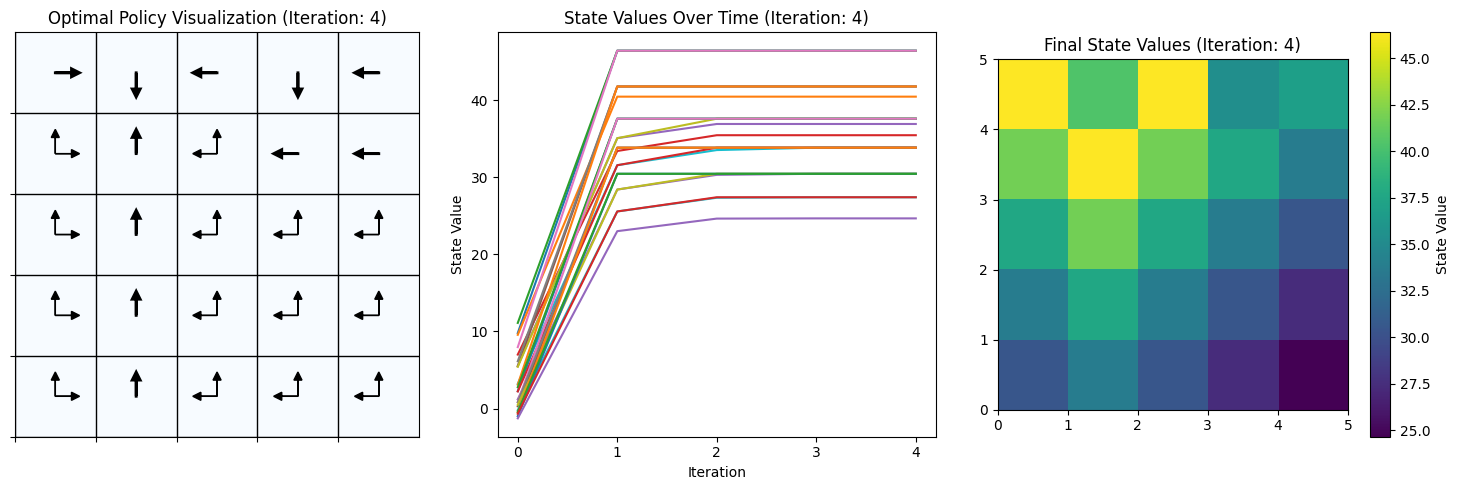

In [13]:
policy_total, state_values_over_time = policy_iteration_state_values(env, gamma=0.9, starting_policy=random_policy)

# Visualize policy 
# [0,1,2,3] # ["south", "north", "east", "west"]

def visualize_policy_and_state_values(policy, state_values_over_time):   
    # Create a 5x5 grid with zeros for policy visualization
    grid_policy = np.zeros((5, 5))

    # Plot the policy grid
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(grid_policy, cmap='Blues', extent=[0, 5, 0, 5])
    plt.title(f'Optimal Policy Visualization (Iteration: {len(state_values_over_time) - 1})')

    # Add grid lines
    plt.grid(which='both', color='black', linestyle='-', linewidth=1)

    # Set ticks to show grid lines
    plt.xticks(np.arange(0, 5, 1), [])
    plt.yticks(np.arange(0, 5, 1), [])


    # Set the limits of the plot
    plt.xlim(0, 5)
    plt.ylim(0, 5)

    # Convert policy to arrow directions by mapping the policy to the correct action
    for i in range(5):
        for j in range(5):
            actions = policy[i, j]
            # South
            if actions[0] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, 0, -0.2, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[0])
            # North
            if actions[1] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, 0, +0.2, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[1])
            # East
            if actions[2] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, +0.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[2])
            # West
            if actions[3] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, -0.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[3])

    # Create a new subplot for state values over time
    plt.subplot(1, 3, 2)
    # Plot the state values in 5x5 plots using the ith row and jth column
    for i in range(5):
        for j in range(5):
            plt.plot(state_values_over_time[:,i,j])
    plt.title(f'State Values Over Time (Iteration: {len(state_values_over_time) - 1})')
    plt.xticks(np.arange(0, len(state_values_over_time), 1))

    plt.xlabel('Iteration')
    plt.ylabel('State Value')

    # Create a third subplot for the final state values
    plt.subplot(1, 3, 3)
    plt.imshow(state_values_over_time[-1], cmap='viridis', extent=[0, 5, 0, 5])
    plt.title(f'Final State Values (Iteration: {len(state_values_over_time) - 1})')
    plt.colorbar(label='State Value')

    # Show the plots
    plt.tight_layout()
    plt.show()

visualize_policy_and_state_values(policy_total[-1], state_values_over_time)


# b) Modification to Value Iteration

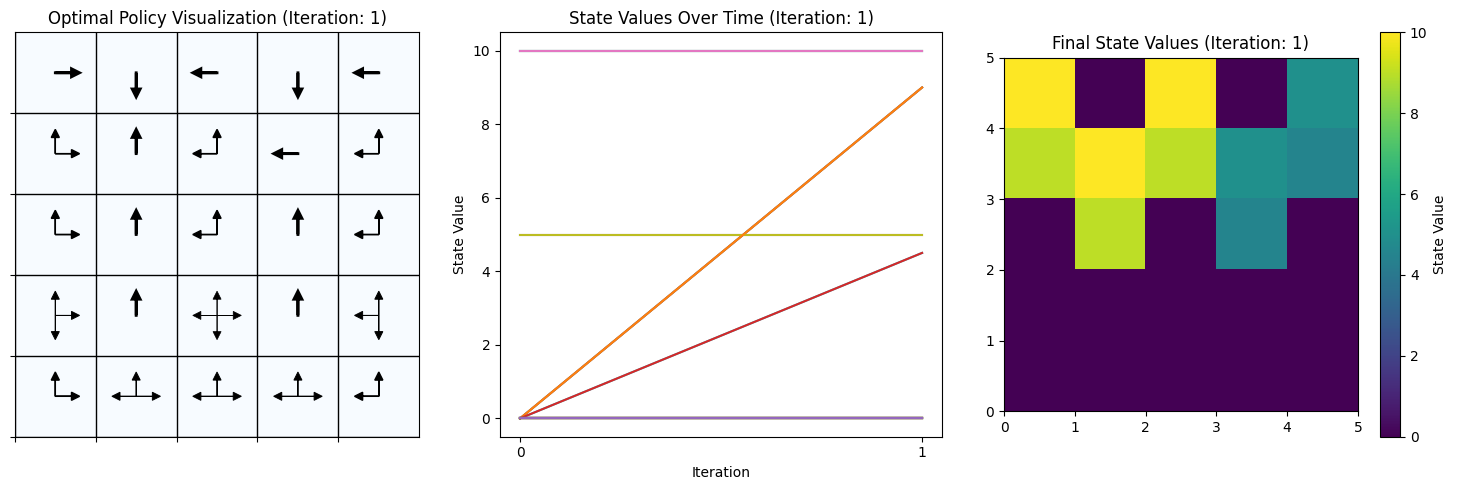

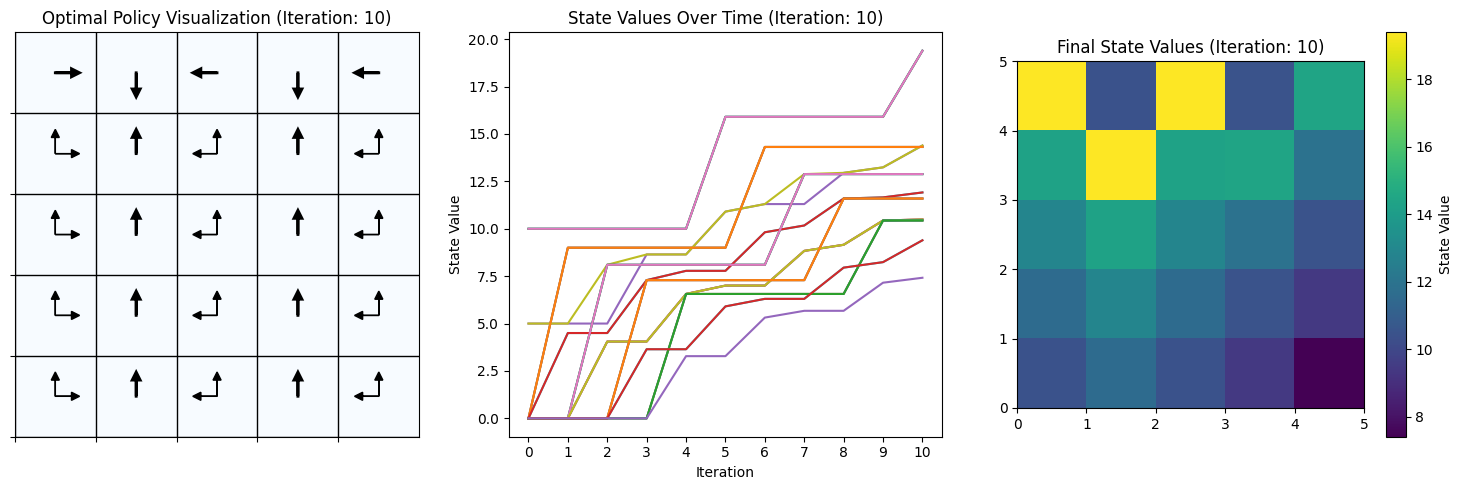

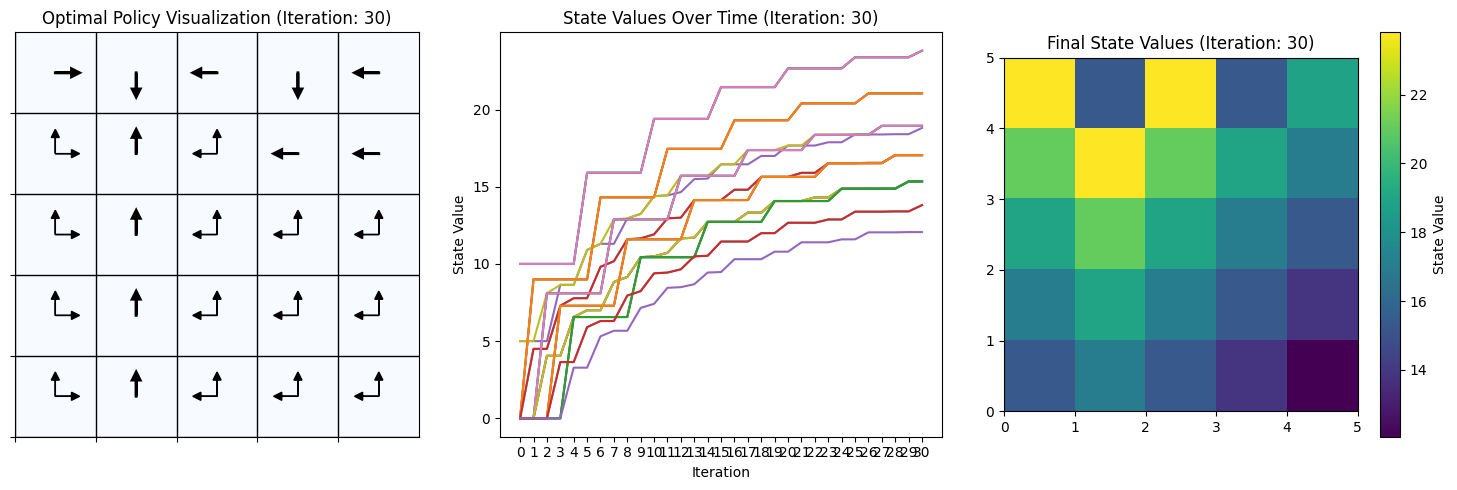

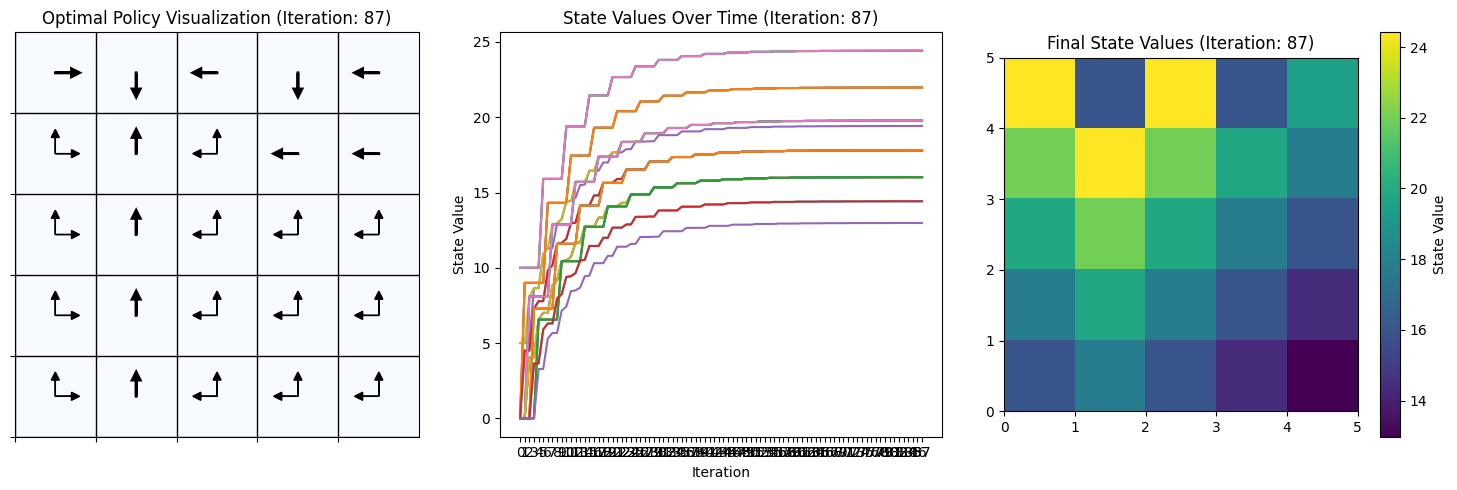

In [19]:
def value_iteration(env, gamma=0.9, threshold=1e-3):
    state_values_over_time = []
    policy_over_time = []

    while True:
        if state_values_over_time:
            old_state_values = state_values_over_time[-1]
        else:
            old_state_values = np.zeros((env.grid_size, env.grid_size))
        
        new_state_values = np.zeros((env.grid_size, env.grid_size))
        for i in range(env.grid_size):
            for j in range(env.grid_size):
                neighboring_state_values = []
                for action in env.action_space:
                    agent_position, reward = env.step(action, (i, j))
                    neighboring_state_values.append(reward + gamma * old_state_values[agent_position[0], agent_position[1]])
                highest_value = np.max(neighboring_state_values)
                new_state_values[i, j] = highest_value
        
        if np.max(np.abs(new_state_values - old_state_values)) < threshold:
            break
        
        state_values_over_time.append(new_state_values.copy())
        current_policy = policy_improvement(env, new_state_values, gamma)
        policy_over_time.append(current_policy)
    
    state_values_over_time = np.array(state_values_over_time)
    policy_over_time = np.array(policy_over_time)
    return policy_over_time, state_values_over_time

policy_over_time, state_values_over_time = value_iteration(env, gamma=0.9, threshold=1e-3)
steps_to_visualize = [1, 10, 30, len(state_values_over_time) - 1]
for step in steps_to_visualize:
    visualize_policy_and_state_values(policy_over_time[step], state_values_over_time[:step+1])



Analysis: 
- Using general policy iteration, the policy converges very stably and quickly in only a couple of iterations (here only 3 iterations).
- Using value iteration, the policy converges more slowly, but also very stably.
- Of course, value iteration is much more computationally inexpensive than policy iteration, since it only evalueates the value function once each iteration. 
- As we can see though, the values reached in the final iteration are not as good as the ones reached using general policy iteration. This is the case because the policy is updated right after on evaluation step, and not after the value function has converged.

In the end, both methods get to the same optimal policy. 

## c) GPI with Action Value Function 

Conceptual difference:
When using the action value function, we are taking the max over all actions for each state, and then updating the value function for each state.
When using the state value function, we are updating the value function for each state based on the expected return of each action in that state.


In [15]:
# Implementation of action value iteration with bellman equation as in exercise 2.1 (adjusted for no teleportation)

def policy_evaluation_action_values(env, gamma=0.9, threshold=1e-3, policy=random_policy):
    action_values = np.zeros((env.grid_size, env.grid_size, len(env.action_space)))
    action_values_total = np.array([action_values.copy()])
    iteration_count = 0 
    
    while True:
        iteration_count += 1  
        new_action_values = np.zeros((env.grid_size, env.grid_size, len(env.action_space)))
        # Iterate over all states
        for i in range(env.grid_size):
            for j in range(env.grid_size):
                # Update state value using the action value bellman equation for each state
                for action in env.action_space:
                    agent_position, reward = env.step(action, (i, j))
                    if agent_position == (0, 1):
                        new_action_values[i, j, action] = 10 + gamma * action_values_total[-1][4, 1, action]
                    elif agent_position == (0, 3):
                        new_action_values[i, j, action] = 5 + gamma * action_values_total[-1][2, 3, action]
                    else:
                        # Compute value function using the bellman equation for each state and action
                        expected_value = 0
                        for next_action in env.action_space:
                            next_action_idx = env.action_space.index(next_action)
                            expected_value += policy[agent_position[0], agent_position[1], next_action_idx] * action_values_total[-1][agent_position[0], agent_position[1], next_action_idx]
                        
                        # Update action-value using the Bellman equation for Q(s, a)
                        new_action_values[i, j, action] = reward + gamma * expected_value

        action_values_total = np.append(action_values_total, [new_action_values.copy()], axis=0)
        
        # Check for convergence
        if np.max(np.abs(new_action_values - action_values)) < threshold:
            break
        
        action_values = new_action_values
    
    print(f"{iteration_count} iterations to evaluate action values")
    return np.array(action_values_total)

# Improve policy 
def policy_improvement_action_values(env, action_values):
    new_policy = np.zeros((5, 5, 4))
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i,j) == (0, 1):
                new_policy[i, j, :] = [1, 0, 0, 0]
            elif (i,j) == (0, 3):
                new_policy[i, j, :] = [1, 0, 0, 0]
            else:
                highest_value = np.max(action_values[i, j, :])
                best_actions = np.where(action_values[i, j, :] == highest_value)[0]
                new_policy[i, j, best_actions] = 1 / len(best_actions)
    return new_policy



In [16]:
# Implementing general policy iteration using 1-step lookahead with value function

# Define random policy
random_policy = 0.25 * np.ones((5, 5, 4))

def policy_iteration_action_values(env, gamma=0.9, threshold=1e-6, starting_policy=random_policy):
    # Compute starting state values
    policy_total = []
    starting_action_values_total = policy_evaluation_action_values(env, policy=starting_policy)
    new_action_values = starting_action_values_total[-1]
    action_values_over_time = np.array([new_action_values.copy()])
    policy_total.append(policy_improvement_action_values(env, new_action_values))

    while True:
        # Compute state values
        current_action_values_total = policy_evaluation_action_values(env, policy=policy_total[-1])
        current_action_values = current_action_values_total[-1]
        action_values_over_time = np.append(action_values_over_time, [current_action_values.copy()], axis=0)
        # Improve policy
        policy_total.append(policy_improvement_action_values(env, current_action_values))
        # Check for convergence
        if np.array_equal(policy_total[-1], policy_total[-2]):
            break
    return policy_total, action_values_over_time


31 iterations to evaluate action values
89 iterations to evaluate action values
89 iterations to evaluate action values
89 iterations to evaluate action values


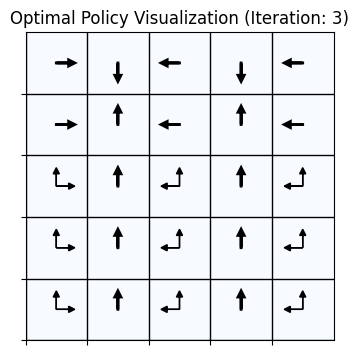

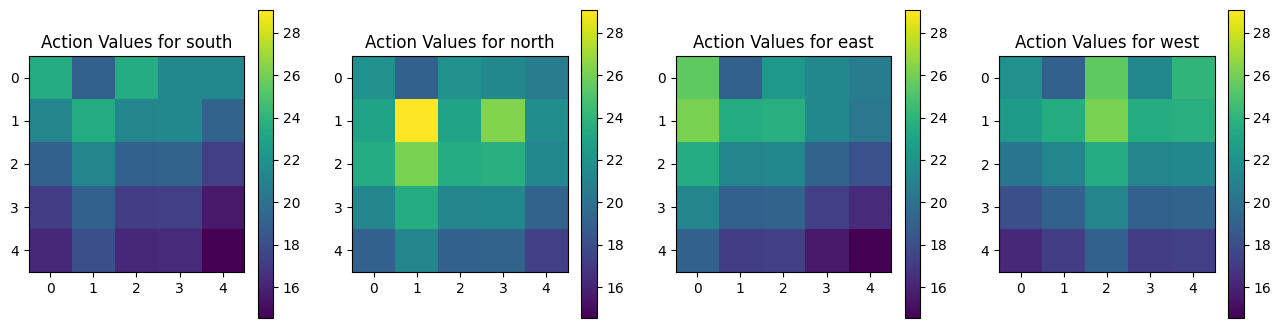

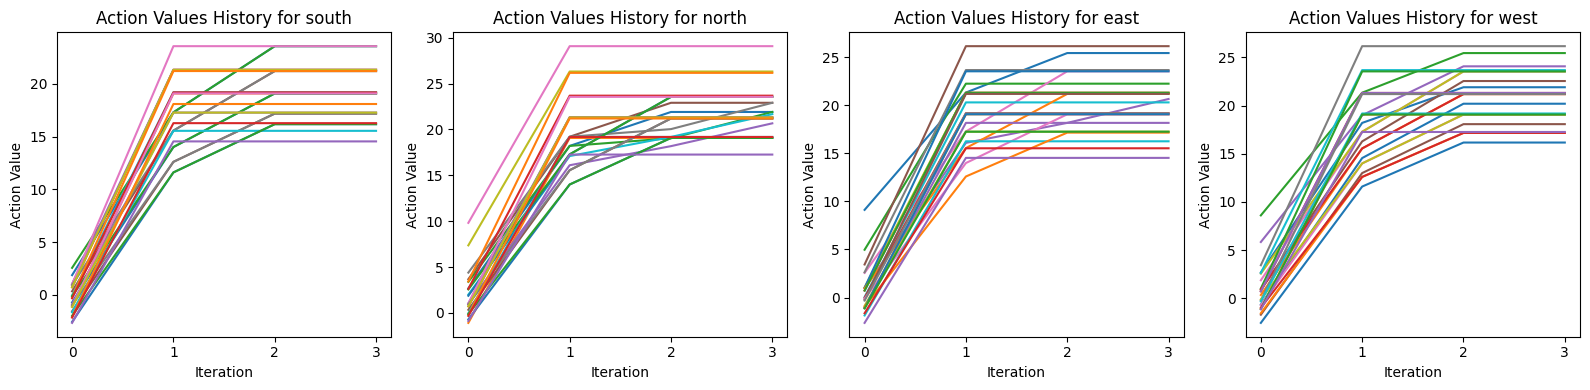

In [17]:
policy_total, action_values_over_time = policy_iteration_action_values(env, gamma=0.9, starting_policy=random_policy)

def visualize_policy_and_action_values(policy, action_values_over_time):
    # Create a 5x5 grid with zeros for policy visualization
    grid_policy = np.zeros((5, 5))

    # Plot the policy grid
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(grid_policy, cmap='Blues', extent=[0, 5, 0, 5])
    plt.title(f'Optimal Policy Visualization (Iteration: {len(action_values_over_time) - 1})')

    # Add grid lines            
    plt.grid(which='both', color='black', linestyle='-', linewidth=1)

    # Set ticks to show grid lines
    plt.xticks(np.arange(0, 5, 1), [])
    plt.yticks(np.arange(0, 5, 1), [])

    # Set the limits of the plot
    plt.xlim(0, 5)
    plt.ylim(0, 5)

    # Convert policy to arrow directions by mapping the policy to the correct action
    for i in range(5):
        for j in range(5):
            actions = policy[i, j]
            # South
            if actions[0] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, 0, -0.2, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[0])
            # North
            if actions[1] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, 0, +0.2, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[1])
            # East
            if actions[2] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, +0.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[2])
            # West
            if actions[3] > 0:
                plt.arrow(j + 0.5, 5 - i - 0.5, -0.2, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', linewidth=2 * actions[3])

    # Create subplots for each action
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Plot the action values for each action
    # Find the min and max values across all action values to ensure consistent color mapping
    vmin = np.min(action_values_over_time[-1, :, :, :])
    vmax = np.max(action_values_over_time[-1, :, :, :])
    
    for action_index in range(4):
        # Extract the action values for the current action
        action_values_to_plot = action_values_over_time[-1, :, :, action_index]
        
        # Plot the values in colors with consistent color mapping
        cax = axes[action_index].imshow(action_values_to_plot, cmap='viridis', vmin=vmin, vmax=vmax)
        fig.colorbar(cax, ax=axes[action_index])
        axes[action_index].set_title(f'Action Values for {env.convert_action_to_direction(action_index)}')

    # Plot the history of the action values for each action
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for action_index in range(4):
        # Extract the action values history for the current action
        action_values_history = action_values_over_time[:, :, :, action_index]
        
        # Plot the history of the action values
        for i in range(5):
            for j in range(5):
                axes[action_index].plot(action_values_history[:, i, j])
        
        axes[action_index].set_title(f'Action Values History for {env.convert_action_to_direction(action_index)}')
        axes[action_index].set_xlabel('Iteration')
        axes[action_index].set_ylabel('Action Value')
        axes[action_index].set_xticks(np.arange(0, len(action_values_history), 1))


    plt.tight_layout()
    plt.show()

visualize_policy_and_action_values(policy_total[-1], action_values_over_time)

Analysis:
- Interestingly, the policy doesnt converge to the same optimal policy as in the previous exercises, but to a slightly different one. It seems to me like the policy using the action values has a smaller "scope", since the decision to go into the B cycle is made using action value functions for the whole column 3, while using state value functions, the A cycle is preferred for position (1, 3). 
- The convergence seems to be of similar speed to the one using state value functions, since the number of policy iterations is again only 3, while the number of iterations to evaluate the action values is 89, like when using state value functions.